# Bibliotecas de Treinamento

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
from collections import Counter
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
import kagglehub
# Download latest version
dataset_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [ ]:
# Se você estiver usando Kaggle ou outro ambiente,
# pode adaptar o trecho de código a seguir para carregar o dataset
# import kagglehub
# dataset_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

# No Google Colab, caso você tenha baixado manualmente ou montado Drive, ajuste 'dataset_path' conforme necessário.
# Exemplo:
# dataset_path = "/content/covid19-radiography-database"

def load_dataset(dataset_path):
    """
    Carrega as imagens e rótulos a partir da estrutura de diretórios do dataset.

    Parâmetros:
        dataset_path (str): Caminho para o diretório onde está o dataset

    Retorno:
        images (list): Lista com caminhos de cada imagem.
        labels (list): Lista com o índice da classe correspondente a cada imagem.
        class_map (dict): Dicionário que mapeia o índice da classe para o nome da classe (pasta).
    """
    images = []
    labels = []
    class_map = {}

    base_path = os.path.join(dataset_path, 'COVID-19_Radiography_Dataset')
    class_folders = [folder for folder in os.listdir(base_path)
                     if os.path.isdir(os.path.join(base_path, folder))]

    for idx, class_folder in enumerate(class_folders):
        class_path = os.path.join(base_path, class_folder)
        images_path = os.path.join(class_path, 'images')

        if os.path.exists(images_path):
            class_map[idx] = class_folder
            for image_filename in os.listdir(images_path):
                image_path = os.path.join(images_path, image_filename)
                images.append(image_path)
                labels.append(idx)

    return images, labels, class_map


In [ ]:
# Transformações (Redimensiona para 224x224, ToTensor e Normalize com estatísticas do ImageNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

In [ ]:
class XRayDataset(Dataset):
    """
    Classe personalizada para carregar as imagens e rótulos em um objeto Dataset.
    """
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]
        img = Image.open(image_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# Carregando as imagens, rótulos e mapeamento de classes
images, labels, class_map = load_dataset(dataset_path)
dataset = XRayDataset(images, labels, transform=transform)


In [ ]:
# Divisão em treino (80%) e validação (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
# Verificação de quantas imagens por classe em cada conjunto
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
val_labels = [val_dataset[i][1] for i in range(len(val_dataset))]
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)

print("Quantidade de imagens por classe no TREINO:")
for idx, count in train_counts.items():
    print(f"{class_map[idx]}: {count} imagens")

print("\nQuantidade de imagens por classe na VALIDAÇÃO:")
for idx, count in val_counts.items():
    print(f"{class_map[idx]}: {count} imagens")


Quantidade de imagens por classe no TREINO:
Normal: 8136 imagens
Viral Pneumonia: 1061 imagens
COVID: 2957 imagens
Lung_Opacity: 4778 imagens

Quantidade de imagens por classe na VALIDAÇÃO:
COVID: 659 imagens
Normal: 2056 imagens
Viral Pneumonia: 284 imagens
Lung_Opacity: 1234 imagens


In [ ]:
# ---------------
# Carregando ResNet50 pré-treinada
# ---------------
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


In [ ]:
# Ajuste da última camada (fc) para o número de classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_map))

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Verifica se há GPU disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Listas para acompanhar métricas
epochs_list = []
loss_list = []
accuracy_list = []

# Defina o número de épocas (por exemplo, 3, mas ajuste conforme necessidade)
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images_batch, labels_batch in train_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    epochs_list.append(epoch + 1)
    loss_list.append(epoch_loss)
    accuracy_list.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%")


print("Treinamento concluído!")


Epoch 1/3, Loss: 0.2930, Accuracy: 89.13%
Epoch 2/3, Loss: 0.1908, Accuracy: 93.05%
Epoch 3/3, Loss: 0.1480, Accuracy: 94.70%
Treinamento concluído!


In [ ]:
# Monta o Drive para salvar o modelo, caso use Google Colab
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/Treinamento modelos Raio-x/Modelos treinados/ResNet50.pth"
torch.save(model.state_dict(), save_path)
print(f"Modelo salvo em: {save_path}")


Mounted at /content/drive
Modelo salvo em: /content/drive/MyDrive/Treinamento modelos Raio-x/Modelos treinados/ResNet50.pth


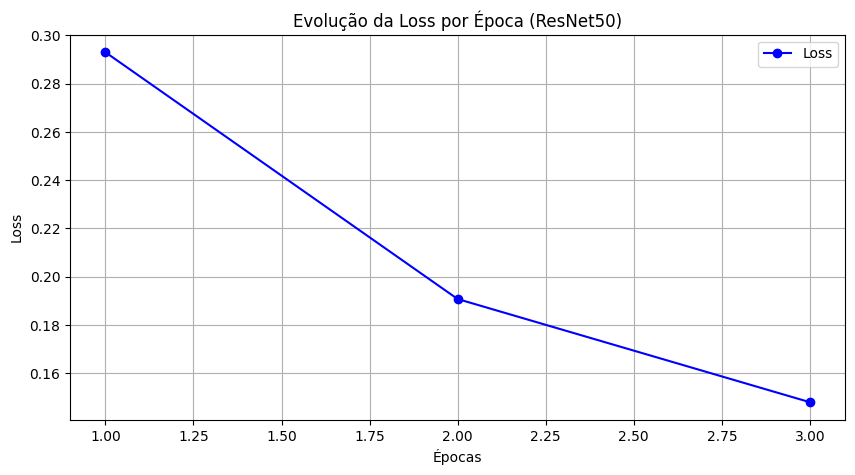

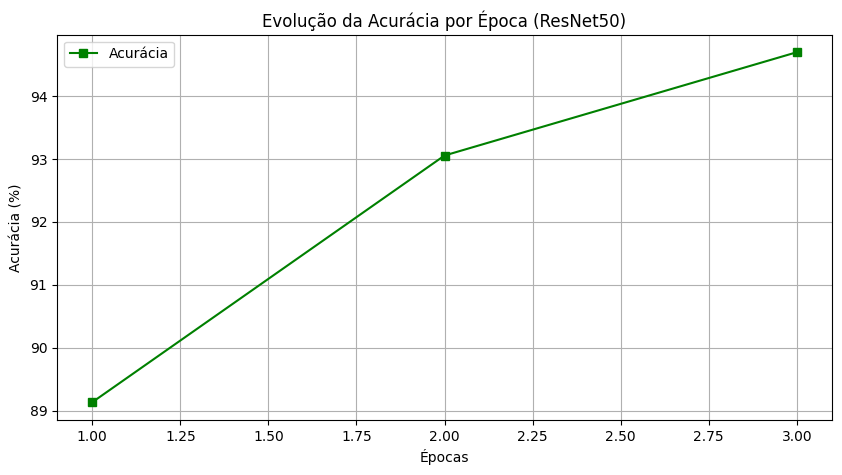

In [ ]:
# Plot da evolução da perda (Loss)
plt.figure(figsize=(10,5))
plt.plot(epochs_list, loss_list, marker='o', linestyle='-', color='b', label='Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Evolução da Loss por Época (ResNet50)')
plt.legend()
plt.grid()
plt.show()

# Plot da evolução da acurácia
plt.figure(figsize=(10,5))
plt.plot(epochs_list, accuracy_list, marker='s', linestyle='-', color='g', label='Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia (%)')
plt.title('Evolução da Acurácia por Época (ResNet50)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# ----------------
# Validação
# ----------------
model.eval()
val_loss = 0.0
correct = 0
total = 0

class_correct = Counter()
class_total = Counter()
class_losses = Counter()

all_preds = []
all_labels = []

with torch.no_grad():
    for images_batch, labels_batch in val_loader:
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

        # Cálculos por classe
        for i in range(labels_batch.size(0)):
            label = labels_batch[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == labels_batch[i]:
                class_correct[label] += 1

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100.0 * correct / total

print(f"\nValidation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")



Validation Loss: 0.2636, Accuracy: 91.21%



Matriz de Confusão:
[[2032   18    0    6]
 [ 206 1016    0   12]
 [  46    3  201   34]
 [  41    6    0  612]]

Relatório de Classificação (precision, recall, f1-score, etc.):
Normal: Precision: 0.87, Recall: 0.99, F1-score: 0.93, Suporte: 2056.0
Lung_Opacity: Precision: 0.97, Recall: 0.82, F1-score: 0.89, Suporte: 1234.0
Viral Pneumonia: Precision: 1.00, Recall: 0.71, F1-score: 0.83, Suporte: 284.0
COVID: Precision: 0.92, Recall: 0.93, F1-score: 0.93, Suporte: 659.0
macro avg: Precision: 0.94, Recall: 0.86, F1-score: 0.89, Suporte: 4233.0
weighted avg: Precision: 0.92, Recall: 0.91, F1-score: 0.91, Suporte: 4233.0

Acurácia por classe:
Classe COVID: Acurácia: 92.87%, Loss: 0.2735
Classe Normal: Acurácia: 98.83%, Loss: 0.2673
Classe Viral Pneumonia: Acurácia: 70.77%, Loss: 0.2786
Classe Lung_Opacity: Acurácia: 82.33%, Loss: 0.2706


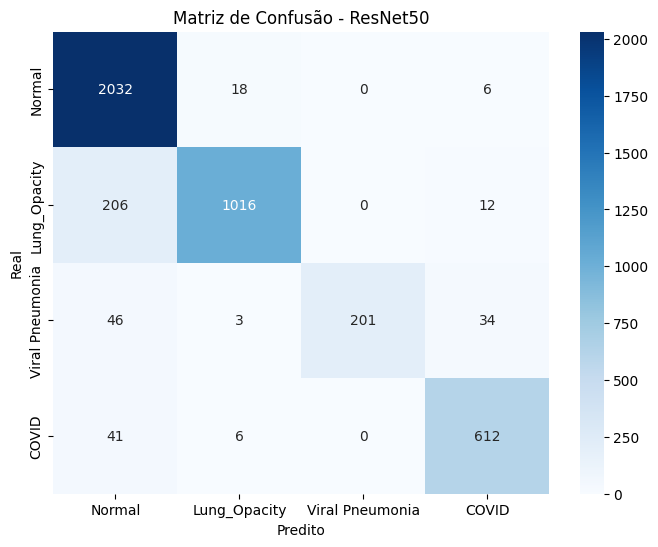

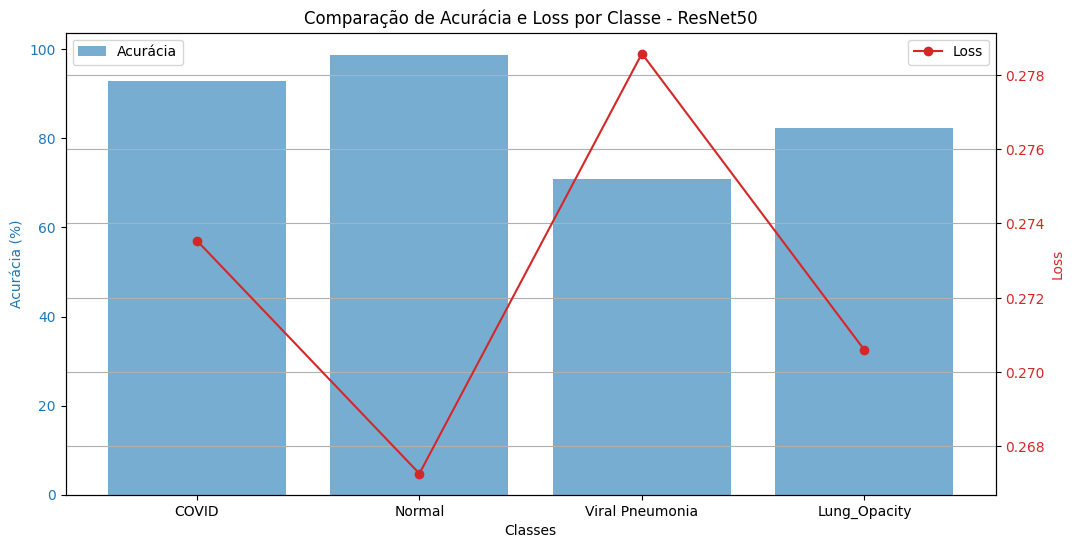

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)
print("\nMatriz de Confusão:")
print(cm)

# Relatório de Classificação
class_names_list = [class_map[idx] for idx in sorted(class_map.keys())]
classification_rep = classification_report(
    all_labels,
    all_preds,
    target_names=class_names_list,
    output_dict=True
)

print("\nRelatório de Classificação (precision, recall, f1-score, etc.):")
for class_label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"{class_label}: "
              f"Precision: {metrics['precision']:.2f}, "
              f"Recall: {metrics['recall']:.2f}, "
              f"F1-score: {metrics['f1-score']:.2f}, "
              f"Suporte: {metrics['support']}")

# Acurácia e Loss por classe
class_accuracies = [
    100.0 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    for idx in class_total.keys()
]
class_losses_avg = [
    class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0
    for idx in class_total.keys()
]
class_names = [class_map[idx] for idx in class_total.keys()]

print("\nAcurácia por classe:")
for name, acc, loss_val in zip(class_names, class_accuracies, class_losses_avg):
    print(f"Classe {name}: Acurácia: {acc:.2f}%, Loss: {loss_val:.4f}")

# Plot da Matriz de Confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_list,
            yticklabels=class_names_list)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - ResNet50")
plt.show()

# Comparação de Acurácia e Loss por Classe
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Classes')
ax1.set_ylabel('Acurácia (%)', color='tab:blue')
ax1.bar(class_names, class_accuracies, color='tab:blue', alpha=0.6, label='Acurácia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(class_names, class_losses_avg, marker='o', linestyle='-', color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Comparação de Acurácia e Loss por Classe - ResNet50')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [ ]:
################################
# (5) VALIDAÇÃO + CONFORMAL
################################
model.eval()
val_loss = 0.0
correct = 0
total = 0

from collections import defaultdict
class_correct = defaultdict(int)
class_total = defaultdict(int)
class_losses = defaultdict(float)

all_preds = []
all_labels = []
all_probs = []  # Para armazenar as probabilidades (softmax)

import torch.nn.functional as F

with torch.no_grad():
    for images_batch, labels_batch in val_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)

        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        val_loss += loss.item()

        # Probabilidades softmax para cada classe
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

        _, predicted = torch.max(outputs, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

        # Armazena predições e rótulos
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

        # Cálculos por classe
        for i in range(labels_batch.size(0)):
            label = labels_batch[i].item()
            class_total[label] += 1
            class_losses[label] += loss.item()
            if predicted[i] == label:
                class_correct[label] += 1

avg_val_loss = val_loss / len(val_loader)
val_accuracy = 100.0 * correct / total

print(f"\nValidation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

# Matriz de Confusão
cm = confusion_matrix(all_labels, all_preds)
print("\nMatriz de Confusão:")
print(cm)

# Relatório de Classificação
class_names_list = [class_map[idx] for idx in sorted(class_map.keys())]
classification_rep = classification_report(
    all_labels,
    all_preds,
    target_names=class_names_list,
    output_dict=True
)



Validation Loss: 0.2636, Accuracy: 91.21%

Matriz de Confusão:
[[2032   18    0    6]
 [ 206 1016    0   12]
 [  46    3  201   34]
 [  41    6    0  612]]



Relatório de Classificação:
Normal: Precision: 0.87, Recall: 0.99, F1-score: 0.93, Suporte: 2056.0
Lung_Opacity: Precision: 0.97, Recall: 0.82, F1-score: 0.89, Suporte: 1234.0
Viral Pneumonia: Precision: 1.00, Recall: 0.71, F1-score: 0.83, Suporte: 284.0
COVID: Precision: 0.92, Recall: 0.93, F1-score: 0.93, Suporte: 659.0
macro avg: Precision: 0.94, Recall: 0.86, F1-score: 0.89, Suporte: 4233.0
weighted avg: Precision: 0.92, Recall: 0.91, F1-score: 0.91, Suporte: 4233.0

Acurácia por classe:
Classe COVID: Acurácia: 92.87%, Loss: 0.2735
Classe Normal: Acurácia: 98.83%, Loss: 0.2673
Classe Viral Pneumonia: Acurácia: 70.77%, Loss: 0.2786
Classe Lung_Opacity: Acurácia: 82.33%, Loss: 0.2706


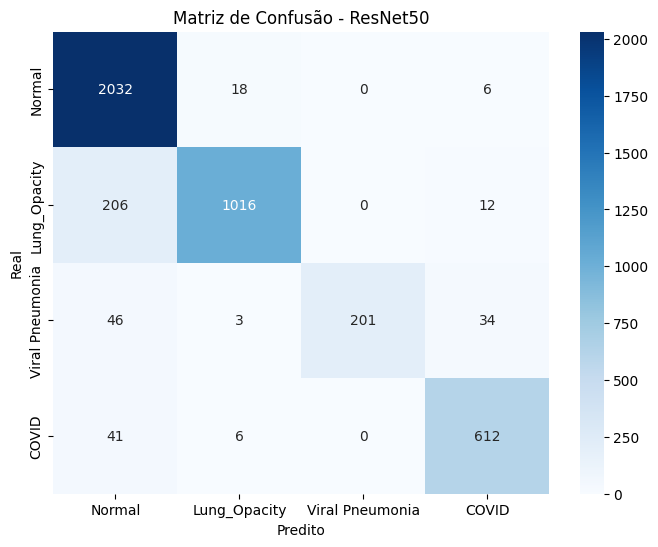

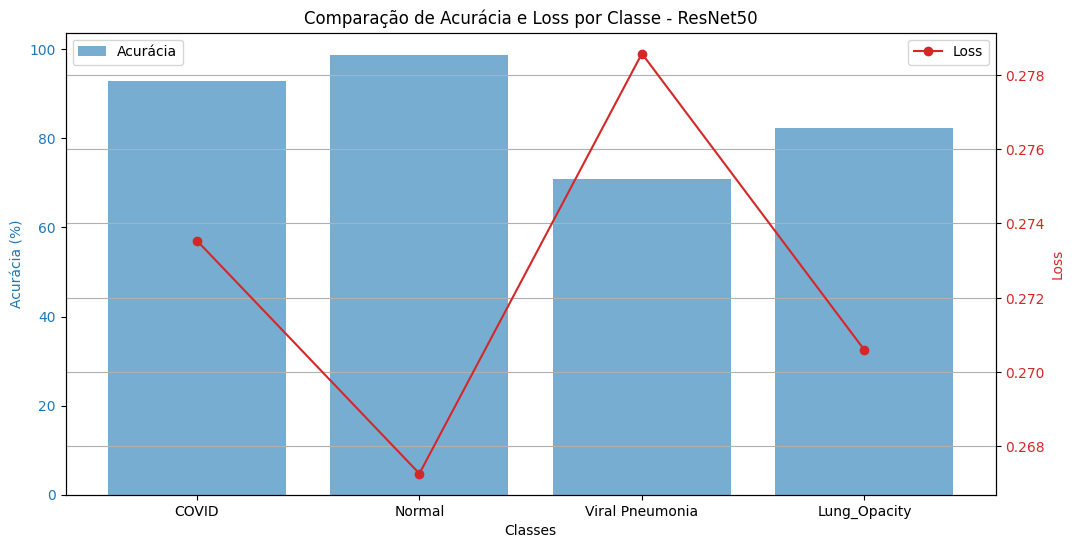

In [ ]:

print("\nRelatório de Classificação:")
for class_label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"{class_label}: "
              f"Precision: {metrics['precision']:.2f}, "
              f"Recall: {metrics['recall']:.2f}, "
              f"F1-score: {metrics['f1-score']:.2f}, "
              f"Suporte: {metrics['support']}")

# Acurácia e Loss por classe
print("\nAcurácia por classe:")
for idx in class_total.keys():
    acc = 100.0 * class_correct[idx] / class_total[idx] if class_total[idx] > 0 else 0
    loss_val = class_losses[idx] / class_total[idx] if class_total[idx] > 0 else 0
    print(f"Classe {class_map[idx]}: Acurácia: {acc:.2f}%, Loss: {loss_val:.4f}")

# Plot da Matriz de Confusão
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_list,
            yticklabels=class_names_list)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - ResNet50")
plt.show()

# Comparação Acurácia x Loss por Classe
class_accuracies = []
class_losses_avg = []
class_names = []

for idx in class_total.keys():
    if class_total[idx] > 0:
        class_accuracies.append(100.0 * class_correct[idx] / class_total[idx])
        class_losses_avg.append(class_losses[idx] / class_total[idx])
        class_names.append(class_map[idx])

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_xlabel('Classes')
ax1.set_ylabel('Acurácia (%)', color='tab:blue')
ax1.bar(class_names, class_accuracies, alpha=0.6, label='Acurácia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(class_names, class_losses_avg, marker='o', linestyle='-', color='tab:red', label='Loss')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title('Comparação de Acurácia e Loss por Classe - ResNet50')
plt.xticks(rotation=45)
plt.grid()
plt.show()



In [ ]:
############################################
# (6) PREDIÇÃO CONFORMAL (MANUAL)
############################################
import numpy as np
from sklearn.model_selection import train_test_split

# all_probs = [N x num_classes]
probs_np = np.array(all_probs)   # shape (N, C)
labels_np = np.array(all_labels) # shape (N,)

# 20% para calibração
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    probs_np, labels_np, test_size=0.2, random_state=42
)

# Passo 1: não conformidade no conjunto de calibração
nonconformity_scores = []
for i in range(len(X_calib)):
    prob = X_calib[i]         # ex: [0.1, 0.7, 0.2, ...]
    true_label = y_calib[i]   # ex: 1
    score = 1.0 - prob[true_label]
    nonconformity_scores.append(score)

nonconformity_scores = np.array(nonconformity_scores)
nonconformity_scores_sorted = np.sort(nonconformity_scores)

# Passo 2: nível de confiança
alpha = 0.05
q_hat = np.quantile(nonconformity_scores_sorted, 1 - alpha)

# Passo 3: gerar conjuntos preditos para dados fora da calibração
prediction_sets = []
correct_in_set = 0

for i in range(len(X_val_conf)):
    prob = X_val_conf[i]
    # Conjunto de classes cuja não conformidade (1 - prob[j]) <= q_hat
    pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]
    prediction_sets.append(pred_set)
    if y_val_conf[i] in pred_set:
        correct_in_set += 1

coverage = correct_in_set / len(X_val_conf)
avg_set_size = np.mean([len(p) for p in prediction_sets])

print("\n✅ Conformal Prediction Manual:")
print(f"Cobertura (acerto): {coverage:.2f} (com 95% de confiança)")
print(f"Tamanho médio do conjunto predito: {avg_set_size:.2f}")



✅ Conformal Prediction Manual:
Cobertura (acerto): 0.96 (com 95% de confiança)
Tamanho médio do conjunto predito: 1.15


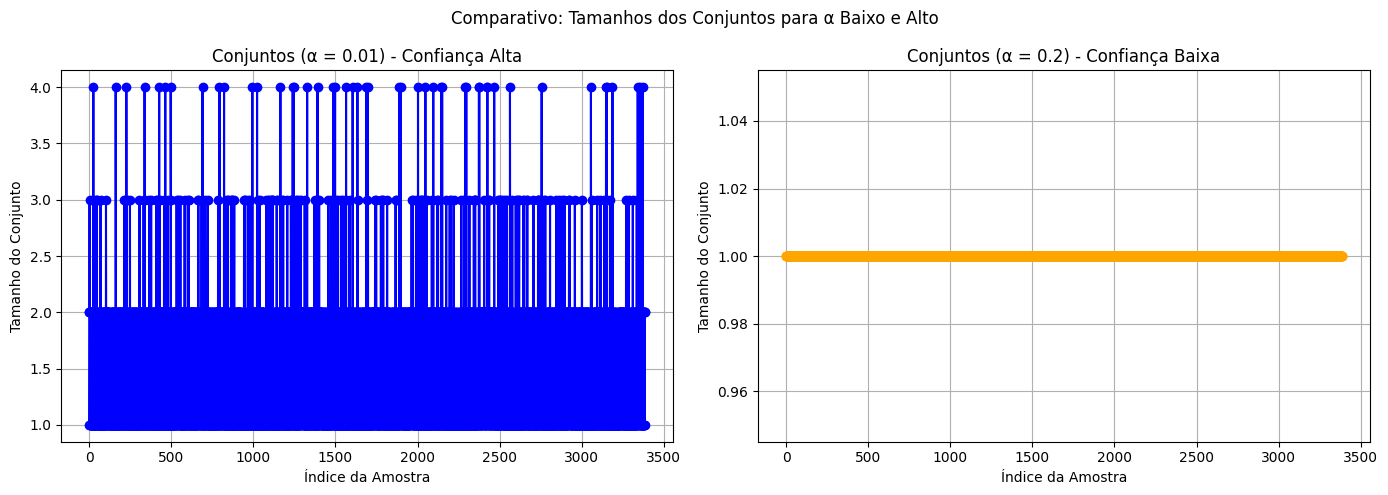


📋 Tabela: Frequência dos Tamanhos (Confiança Alta - α = 0.01)
 Tamanho do Conjunto (α = 0.01)  Quantidade
                              1        1946
                              2        1235
                              3         158
                              4          47

📋 Tabela: Frequência dos Tamanhos (Confiança Baixa - α = 0.20)
 Tamanho do Conjunto (α = 0.20)  Quantidade
                              1        3386


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Supondo que all_probs e all_labels já tenham sido definidos durante a validação
X_val_conf, X_calib, y_val_conf, y_calib = train_test_split(
    np.array(all_probs), np.array(all_labels), test_size=0.2, random_state=42
)

# Função para gerar conjuntos de predição

def generate_prediction_sets(X_probs, y_true, nonconformity_scores, alpha):
    q_hat = np.quantile(nonconformity_scores, 1 - alpha)
    prediction_sets = []
    correct_in_set = 0

    for i in range(len(X_probs)):
        prob = X_probs[i]
        pred_set = [j for j in range(len(prob)) if 1.0 - prob[j] <= q_hat]

        # Correção: se conjunto estiver vazio, incluir a classe de maior probabilidade
        if len(pred_set) == 0:
            pred_set = [int(np.argmax(prob))]

        prediction_sets.append(pred_set)
        if y_true[i] in pred_set:
            correct_in_set += 1

    coverage = correct_in_set / len(X_probs)
    avg_size = np.mean([len(s) for s in prediction_sets])
    return prediction_sets, coverage, avg_size

# Etapa 1: calcular não conformidade para calibração
nonconformity_scores = [1 - X_calib[i][y_calib[i]] for i in range(len(X_calib))]

# Testar alpha menos permissivo (maior confiança)
alpha_low = 0.01
sets_low, cov_low, avg_low = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_low)
set_sizes_low = [len(s) for s in sets_low]

# Testar alpha mais permissivo (menor confiança)
alpha_high = 0.20
sets_high, cov_high, avg_high = generate_prediction_sets(X_val_conf, y_val_conf, nonconformity_scores, alpha_high)
set_sizes_high = [len(s) for s in sets_high]

# Gráficos
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(range(len(set_sizes_low)), set_sizes_low, marker='o', linestyle='-', color='blue')
axs[0].set_title(f"Conjuntos (α = {alpha_low}) - Confiança Alta")
axs[0].set_xlabel("Índice da Amostra")
axs[0].set_ylabel("Tamanho do Conjunto")
axs[0].grid(True)

axs[1].plot(range(len(set_sizes_high)), set_sizes_high, marker='o', linestyle='-', color='orange')
axs[1].set_title(f"Conjuntos (α = {alpha_high}) - Confiança Baixa")
axs[1].set_xlabel("Índice da Amostra")
axs[1].set_ylabel("Tamanho do Conjunto")
axs[1].grid(True)

plt.suptitle("Comparativo: Tamanhos dos Conjuntos para α Baixo e Alto")
plt.tight_layout()
plt.show()

# Tabelas comparativas
unique_low, count_low = np.unique(set_sizes_low, return_counts=True)
df_low = pd.DataFrame({
    "Tamanho do Conjunto (α = 0.01)": unique_low,
    "Quantidade": count_low
})

unique_high, count_high = np.unique(set_sizes_high, return_counts=True)
df_high = pd.DataFrame({
    "Tamanho do Conjunto (α = 0.20)": unique_high,
    "Quantidade": count_high
})

print("\n📋 Tabela: Frequência dos Tamanhos (Confiança Alta - α = 0.01)")
print(df_low.to_string(index=False))

print("\n📋 Tabela: Frequência dos Tamanhos (Confiança Baixa - α = 0.20)")
print(df_high.to_string(index=False))


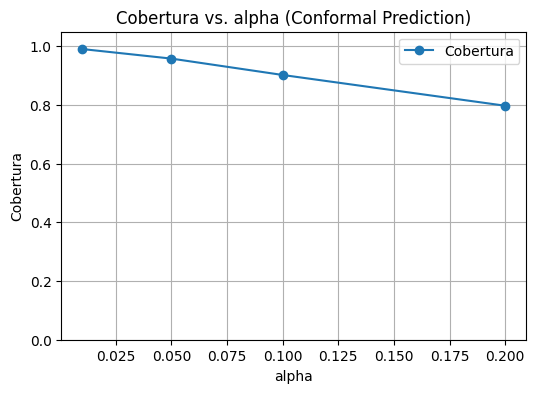

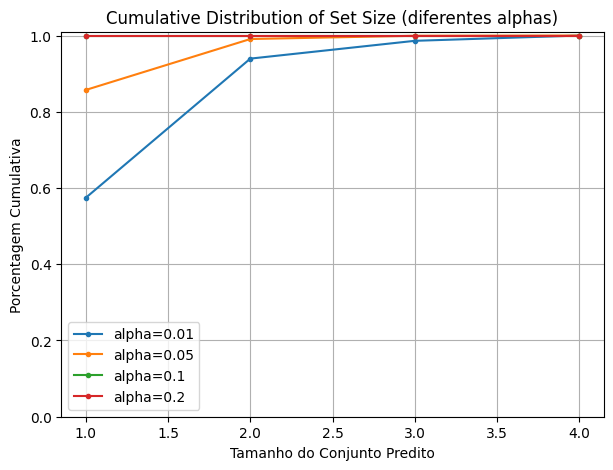

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# Supomos que você JÁ possua:
# X_calib, y_calib, X_val_conf, y_val_conf
# onde:
# - X_calib: probabilidades softmax do conjunto de calibração
# - y_calib: rótulos corretos do conjunto de calibração
# - X_val_conf: probabilidades softmax do conjunto de validação (exceto calibração)
# - y_val_conf: rótulos corretos do conjunto de validação
# -------------------------------------------------

def compute_prediction_sets(probs_val, q_hat):
    """
    Retorna a lista de conjuntos preditos, onde cada conjunto
    contém as classes j cujo (1 - prob[j]) <= q_hat.
    """
    prediction_sets = []
    for prob in probs_val:
        pred_set = [j for j in range(len(prob)) if (1.0 - prob[j]) <= q_hat]
        prediction_sets.append(pred_set)
    return prediction_sets

def coverage_and_size(prediction_sets, true_labels):
    """
    Calcula a cobertura (percentual de vezes em que o rótulo verdadeiro
    está no conjunto) e o tamanho médio dos conjuntos.
    """
    correct_in_set = 0
    for pset, true_label in zip(prediction_sets, true_labels):
        if true_label in pset:
            correct_in_set += 1
    coverage = correct_in_set / len(true_labels)
    avg_size = np.mean([len(pset) for pset in prediction_sets])
    return coverage, avg_size

# 1) Calcular não conformidade no conjunto de calibração (1 - prob da classe correta)
scores_calib = 1.0 - np.array([X_calib[i, y_calib[i]] for i in range(len(X_calib))])
scores_calib_sorted = np.sort(scores_calib)

# 2) Escolher múltiplos valores de alpha para ver o efeito
alpha_values = [0.01, 0.05, 0.1, 0.2]  # Exemplo
coverages = []
avg_sizes = []

# Para plot de Cumulative Distribution of Set Size
cdf_data = {}  # dict alpha -> array com tamanhos

N_val = len(X_val_conf)  # número de amostras na parte de validação

for alpha in alpha_values:
    # Determinar o quantil q_hat
    q_hat = np.quantile(scores_calib_sorted, 1 - alpha)

    # Formar conjuntos preditos
    prediction_sets = compute_prediction_sets(X_val_conf, q_hat)

    # Cobertura e tamanho médio
    coverage, avg_size = coverage_and_size(prediction_sets, y_val_conf)
    coverages.append(coverage)
    avg_sizes.append(avg_size)

    # Vamos também guardar o tamanho de cada conjunto predito para plot de distribuição
    set_sizes = [len(ps) for ps in prediction_sets]
    cdf_data[alpha] = np.array(set_sizes)

####################################
# Plot 1: Coverage vs. alpha
####################################
plt.figure(figsize=(6,4))
plt.plot(alpha_values, coverages, marker='o', label='Cobertura')
plt.xlabel('alpha')
plt.ylabel('Cobertura')
plt.title('Cobertura vs. alpha (Conformal Prediction)')
plt.ylim([0, 1.05])
plt.grid()
plt.legend()
plt.show()

####################################
# Plot 2: Cumulative Distribution of Set Size
####################################
# Aqui, para cada alpha, calculamos a porcentagem cumulativa
# de exemplos que têm conjunto predito de tamanho <= k.

max_set_size = 0
for alpha in alpha_values:
    max_size_alpha = cdf_data[alpha].max()
    if max_size_alpha > max_set_size:
        max_set_size = max_size_alpha

# Vamos criar valores de x (tamanho do conjunto) de 1 até max_set_size.
x_vals = np.arange(1, max_set_size + 1)

plt.figure(figsize=(7,5))
for alpha in alpha_values:
    sizes = cdf_data[alpha]
    cdf = [(sizes <= k).mean() for k in x_vals]
    plt.plot(x_vals, cdf, marker='.', linestyle='-', label=f'alpha={alpha}')

plt.xlabel('Tamanho do Conjunto Predito')
plt.ylabel('Porcentagem Cumulativa')
plt.title('Cumulative Distribution of Set Size (diferentes alphas)')
plt.ylim([0,1.01])
plt.grid()
plt.legend()
plt.show()
